In [56]:
import emcee
import corner
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from statistics_functions import chi_squared

In [2]:
data = pd.read_csv('data/reflex70.txt', header=7, sep='|', skiprows=[range(6), 8],on_bad_lines='warn', skipfooter=1, skipinitialspace=True).rename(columns=lambda x: x.strip())
#data = data.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
#data['Name'].values.strip()
data = data.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
#data['Name']

mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1).rename(columns=lambda x: x.strip())
mcxccls = mcxccls.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
mcxc_data = mcxccls[mcxccls['Sub-Cat']=='REFLEX'][['AName', 'L500']].rename(columns={'AName': 'Name'})
#mcxc_data

L500s=[]
ObsLum_mcxc=[]
for name in mcxc_data['Name']:
    L500s.append(mcxc_data[mcxc_data['Name']==name]['L500'].values[0])
    ObsLum_mcxc.append(data[data['Name']==name]['ObsLum'].values)
    
mcxc_data_clean=mcxc_data.dropna()
data_clean=data[['Name', 'Flux', 'e_Flux', 'ObsLum', 'LumCor', 'z']].dropna()

comb = pd.merge(mcxc_data_clean, data_clean, on='Name', how='inner', sort=True)
comb

/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_51779/2159843122.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('data/reflex70.txt', header=7, sep='|', skiprows=[range(6), 8],on_bad_lines='warn', skipfooter=1, skipinitialspace=True).rename(columns=lambda x: x.strip())
/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_51779/2159843122.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1).rename(columns=lambda x: x.strip())


,Name,L500,Flux,e_Flux,ObsLum,LumCor,z
0,1ES0657,20.425901,9.079,7.9,21.646,23.028,0.2965
1,A0013,1.236332,6.071,11.3,1.285,1.353,0.0940
2,A0022,2.872451,5.910,12.1,2.909,3.232,0.1410
3,A0042,1.404549,4.836,13.3,1.491,1.521,0.1120
4,A0085,5.100085,74.215,3.2,5.293,5.631,0.0555
...,...,...,...,...,...,...,...
330,S1101,1.811143,23.412,7.2,1.738,1.998,0.0564
331,S1136,0.504007,5.273,20.5,0.516,0.549,0.0643
332,USGC S152,0.073319,10.929,6.8,0.059,0.072,0.0155
333,Zw0258.9,3.711221,4.973,15.8,3.704,4.209,0.1712


In [4]:
d_L = cosmo.comoving_distance(comb['z']).to(u.m).value #(return meters)
#flux_var=ufloat(comb['Flux'].to_numpy(), comb['e_Flux'].to_numpy())
#Lobs_calc=(comb['Flux'].to_numpy()*u.W*1e-15/u.m**2 * 4*np.pi * d_L**2).to(u.W)
flux_arr=comb['Flux'].to_numpy()*1e-15 # to get in watts
eflux_arr=comb['e_Flux'].to_numpy()
flux_var=np.array([ufloat(flux_arr[i],eflux_arr[i]*flux_arr[i]/100) for i in range(len(flux_arr))])

#originally in units u.W*1e-15/u.m**2 * Mpc**2
Lobs_calc=(flux_var*4*np.pi*d_L**2) * 1e-37 

#Lobs_calc #now in units of 1e37 W
Lobs_err = [L.std_dev for L in Lobs_calc]
#Lobs_err
Lobs_calc

array([15.553510354829951+/-1.228727318031566,
       1.151491243581231+/-0.13011851052467907,
       2.468047427997588+/-0.2986337387877081,
       1.2914801773344928+/-0.17176686358548754,
       4.992960256606127+/-0.15977472821139607,
       1.441490095733439+/-0.07639897507387228,
       1.3449171524043682+/-0.09010944921109267,
       4.136679954985992+/-0.6494587529328006,
       2.399238449590619+/-0.5062393128636207,
       0.1823602455352788+/-0.02917763928564461,
       0.4261976705606648+/-0.04176737171494515,
       0.7468746964724994+/-0.11427182856029242,
       0.4634189064702471+/-0.043097958301732985,
       0.0698798835986977+/-0.009853063587416378,
       4.737446062940791+/-0.49269439054584224,
       1.1501544260574779+/-0.16907270063044924,
       3.3367250496409313+/-0.3837233807087071,
       0.14361970960893417+/-0.01967590021642398,
       1.4616040574549636+/-0.2616271262844384,
       0.6073121652554793+/-0.08866757612729999,
       3.0595396671840396+/-0.4

In [9]:
# MCMC: L_o=(L_c - b)/m 
L_obs_data = comb['ObsLum']
L_obs_var=[L.std_dev for L in Lobs_calc]
L_cor=comb['LumCor']

Text(0, 0.5, 'L_obs')

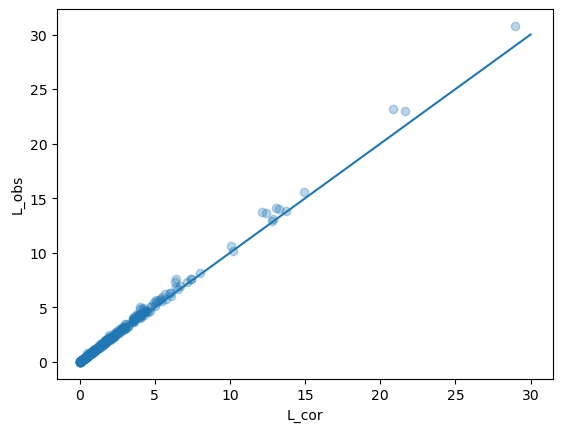

In [91]:
plt.scatter(L_obs_data, L_cor, alpha=0.3)
plt.plot(np.linspace(0,30), np.linspace(0,30))
plt.xlabel('L_cor')
plt.ylabel('L_obs')

In [48]:
def log_lik(p0, L_c, obs, var):
    m=p0[0]
    if np.abs(m)<0.00001:
        return -np.inf
    b=p0[1]
    if np.abs(m)>10 or np.abs(b)>10:
        return -np.inf
    pred=(L_c-b)/m
    return -1*chi_squared(pred, obs, var)/2

In [49]:
p0=[1, 0]
log_lik(p0, L_cor, L_obs_data, L_obs_var)

-332.4872287535209

In [70]:
ndim=2
nwalkers = 32
guess=(1, 0)
p0 = guess+np.random.normal(scale=0.1, size=(nwalkers, ndim))
p0

array([[ 9.22987354e-01, -2.05287763e-01],
       [ 8.28128133e-01,  1.10272828e-01],
       [ 9.55874755e-01, -1.20543368e-03],
       [ 9.58836719e-01, -6.95237454e-02],
       [ 9.29897302e-01, -4.45969653e-02],
       [ 8.99935317e-01,  8.94251008e-02],
       [ 1.01997176e+00,  9.04400352e-02],
       [ 1.09909471e+00, -6.55921976e-02],
       [ 8.90726080e-01, -6.23993417e-02],
       [ 9.46740091e-01, -3.16571627e-02],
       [ 9.93590676e-01, -2.34126118e-03],
       [ 1.29470077e+00, -3.10670600e-02],
       [ 9.71060296e-01,  1.12668179e-02],
       [ 1.02667351e+00,  6.22781810e-02],
       [ 9.81877848e-01,  1.80001193e-02],
       [ 1.14037601e+00, -9.80367054e-02],
       [ 8.60038501e-01,  1.19507454e-01],
       [ 1.07656112e+00,  1.08584683e-01],
       [ 8.78581513e-01,  8.64207073e-02],
       [ 9.67241467e-01,  7.02914730e-02],
       [ 8.97051036e-01, -1.38970125e-01],
       [ 8.63736570e-01, -8.96045245e-02],
       [ 9.86131183e-01, -2.05854527e-01],
       [ 9.

In [71]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_lik, args=[L_cor, L_obs_data, L_obs_var])

In [72]:
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 31.06it/s]


In [73]:
sampler.run_mcmc(state, 5000, progress=True)

100%|███████████████████████████████████████| 5000/5000 [02:41<00:00, 30.97it/s]


State([[1.09465576e+00 8.26191102e-04]
 [1.08453894e+00 1.03672348e-03]
 [1.09158025e+00 9.73752126e-04]
 [1.09942106e+00 7.05673626e-04]
 [1.09320845e+00 7.16189680e-04]
 [1.09152169e+00 7.59715747e-04]
 [1.08900801e+00 1.00381761e-03]
 [1.09599102e+00 8.89190963e-04]
 [1.09273248e+00 8.45610908e-04]
 [1.09442462e+00 6.99905544e-04]
 [1.09463393e+00 7.46770306e-04]
 [1.08742118e+00 1.11455439e-03]
 [1.09012100e+00 1.00256739e-03]
 [1.09360796e+00 7.67400877e-04]
 [1.08495443e+00 1.13041824e-03]
 [1.09317964e+00 6.83960900e-04]
 [1.09684229e+00 1.04338950e-03]
 [1.09125132e+00 6.32745032e-04]
 [1.08732154e+00 8.32094041e-04]
 [1.09735400e+00 8.24419314e-04]
 [1.09912425e+00 5.22090322e-04]
 [1.09105062e+00 1.12562034e-03]
 [1.08205905e+00 9.86243368e-04]
 [1.08377109e+00 7.37764976e-04]
 [1.08305936e+00 1.06620374e-03]
 [1.09652421e+00 8.23147218e-04]
 [1.09015537e+00 7.97363047e-04]
 [1.10464483e+00 6.75382268e-04]
 [1.08240198e+00 8.46479462e-04]
 [1.09923620e+00 8.36230055e-04]
 [1.

In [74]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

(160000, 2)


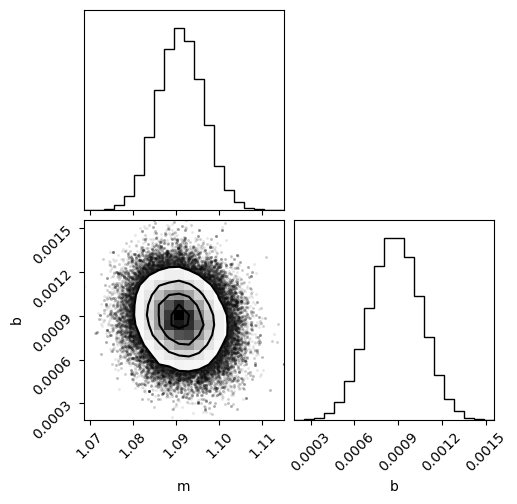

In [93]:
fig = corner.corner(flat_samples, labels=['m', 'b']) 

In [76]:
sampler.get_chain()

array([[[1.09715829e+00, 9.14321728e-04],
        [1.08745227e+00, 8.61115839e-04],
        [1.09298656e+00, 7.39374629e-04],
        ...,
        [1.09432954e+00, 6.09513735e-04],
        [1.08863898e+00, 8.84048585e-04],
        [1.09158577e+00, 9.92009345e-04]],

       [[1.09522228e+00, 9.30422187e-04],
        [1.09045416e+00, 7.49641947e-04],
        [1.09455191e+00, 6.87284786e-04],
        ...,
        [1.09432954e+00, 6.09513735e-04],
        [1.08805412e+00, 9.36734075e-04],
        [1.09158577e+00, 9.92009345e-04]],

       [[1.09522228e+00, 9.30422187e-04],
        [1.09045416e+00, 7.49641947e-04],
        [1.09388258e+00, 6.86598097e-04],
        ...,
        [1.09432954e+00, 6.09513735e-04],
        [1.08514976e+00, 9.02603352e-04],
        [1.09133697e+00, 9.75312488e-04]],

       ...,

       [[1.09480123e+00, 7.76066869e-04],
        [1.08948215e+00, 8.74603477e-04],
        [1.08778223e+00, 1.10381712e-03],
        ...,
        [1.10052926e+00, 9.25640196e-04],
     

In [77]:
tau = sampler.get_autocorr_time()
print(tau)

[31.28564493 29.58276695]


In [87]:
np.median(flat_samples[:,0]), np.median(flat_samples[:,1])

(1.0909995712630418, 0.000879110254766934)

In [89]:
m_err=np.var(flat_samples[:,0]) # var=mean((p-pmean)**2)
m_err

2.791749962344215e-05

In [90]:
b_err=np.var(flat_samples[:,1])
b_err

3.084400548711369e-08

In [94]:
m_uf=ufloat(np.median(flat_samples[:,0]), np.var(flat_samples[:,0]))
b_uf=ufloat(np.median(flat_samples[:,1]), np.var(flat_samples[:,1]))

m_uf, b_uf

(1.0909995712630418+/-2.791749962344215e-05,
 0.000879110254766934+/-3.084400548711369e-08)

In [98]:
L_obs_uf=unp.uarray(comb['ObsLum'], [L.std_dev for L in Lobs_calc])

L_cor_pred=m_uf*L_obs_uf+b_uf

In [104]:
L_cor_uf=unp.uarray(comb['LumCor'], [L.std_dev for L in L_cor_pred])
L_cor_uf

array([23.028+/-1.340541113378252, 1.353+/-0.1419592437286041,
       3.232+/-0.3258092911036202, 1.521+/-0.18739757915186533,
       5.631+/-0.1743142226089883, 1.568+/-0.08335125964024216,
       1.617+/-0.09830937866428917, 5.762+/-0.7085592371353097,
       3.04+/-0.5523068796832792, 0.206+/-0.03183279240240576,
       0.53+/-0.045568186412042216, 0.889+/-0.1246705181986162,
       0.503+/-0.047019856003214434, 0.074+/-0.010749688327175844,
       6.289+/-0.5375293952710681, 1.397+/-0.18445824777896244,
       4.883+/-0.4186420602491998, 0.157+/-0.021466399114276377,
       1.976+/-0.28543508692308345, 0.73+/-0.09673628939708431,
       4.27+/-0.5140453075888746, 4.559+/-0.7033689845053425,
       3.437+/-0.40936123930970875, 1.614+/-0.1433997068558174,
       2.054+/-0.06822248021718864, 2.094+/-1.0637189761939083,
       0.716+/-0.10567969908475343, 1.096+/-0.09261530482476828,
       8.178+/-1.0949130384511656, 0.843+/-0.18267059330137436,
       1.286+/-0.2578959347743869, 0.19